In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
from sklearn.metrics import confusion_matrix
sns.set()

In [58]:
# import pytorch specific utils
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [59]:
# import the datasets
train_dataset = datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [60]:
# set the computation device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [61]:
# construct the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [62]:
# loss and optimizer instantiation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [63]:
# create data loader i.e generators
batch_size = 128
trainloader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

testloader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [64]:
# train the model
epochs = 10

# stuff to store
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

train_accus = np.zeros(epochs)
test_accus = np.zeros(epochs)

for epoch in range(epochs):
    train_batch_losses = []
    test_batch_losses = []

    train_batch_accus = []
    test_batch_accus = []
    
    print("Training Network.....")
    for inputs, targets in trainloader:
        
        #move data to gpu
        inputs, targets = inputs.to(device), targets.to(device)

        # reshape input coz input is size 1 x 28 x 28
        inputs = inputs.view(-1, 784)

        # zero the grad
        optimizer.zero_grad()

        # forwards pass and get losses
        logits = model(inputs)
        train_batch_loss = criterion(logits, targets)
        train_batch_losses.append(train_batch_loss.item())

        # get accus
        # convert from logits to probabilities
        train_logit_probs = torch.exp(logits) / \
                            torch.sum(torch.exp(logits), dim=1).view(-1, 1)
        probs, indices = torch.topk(train_logit_probs, k=1, dim=1,)
        equals = targets.view(-1, 1) == indices
        train_batch_accu = np.mean(equals.detach().cpu().numpy())
        train_batch_accus.append(train_batch_accu)

        # BACKSTEP
        train_batch_loss.backward()
        optimizer.step()


    # Now validate
    print("Evaluating Network.....")
    with torch.no_grad():
        for inputs, targets in testloader:
            
            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            # reshape input coz input is size 1 x 28 x 28
            inputs = inputs.view(-1, 784)

            # forwards pass and get losses
            logits = model(inputs)
            test_batch_loss = criterion(logits, targets)
            test_batch_losses.append(test_batch_loss.item())

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            test_batch_accu = np.mean(equals.cpu().numpy())
            test_batch_accus.append(test_batch_accu)

    print("=" * 50)
    # now getting out to the next epoch - all batches done - store epoch
    # loss and accus
    train_losses[epoch] = np.mean(train_batch_losses)
    test_losses[epoch] = np.mean(test_batch_losses)
    train_accus[epoch] = np.mean(train_batch_accus)
    test_accus[epoch] = np.mean(test_batch_accus)


    print(f"Epoch: {epoch+1}  TrainLoss: {train_losses[epoch]:0.3f}  "
          f"TestLoss: {test_losses[epoch]:0.3f}")
    print(f"          TrainAcc: {train_accus[epoch]:0.3f}  TestAccus: "
          f"{test_accus[epoch]}:0.3f")
    print("=" * 50)

Training Network.....
Evaluating Network.....
Epoch: 1  TrainLoss: 0.421  TestLoss: 0.221
          TrainAcc: 0.892  TestAccus: 0.9357199367088608:0.3f
Training Network.....
Evaluating Network.....
Epoch: 2  TrainLoss: 0.195  TestLoss: 0.163
          TrainAcc: 0.944  TestAccus: 0.9525316455696202:0.3f
Training Network.....
Evaluating Network.....
Epoch: 3  TrainLoss: 0.144  TestLoss: 0.129
          TrainAcc: 0.959  TestAccus: 0.9617286392405063:0.3f
Training Network.....
Evaluating Network.....
Epoch: 4  TrainLoss: 0.113  TestLoss: 0.109
          TrainAcc: 0.967  TestAccus: 0.968057753164557:0.3f
Training Network.....
Evaluating Network.....
Epoch: 5  TrainLoss: 0.092  TestLoss: 0.098
          TrainAcc: 0.974  TestAccus: 0.9720134493670886:0.3f
Training Network.....
Evaluating Network.....
Epoch: 6  TrainLoss: 0.076  TestLoss: 0.091
          TrainAcc: 0.977  TestAccus: 0.9721123417721519:0.3f
Training Network.....
Evaluating Network.....
Epoch: 7  TrainLoss: 0.064  TestLoss: 0.084

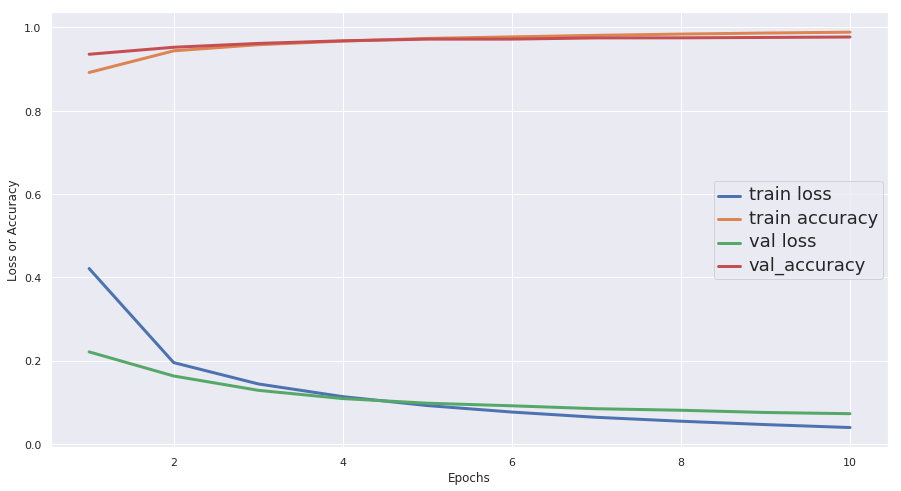

In [66]:
# plot the performance
num_epochs = range(1, epochs+1)
plot_df = pd.DataFrame(data=np.c_[num_epochs,train_losses,train_accus,test_losses,test_accus],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); #

In [67]:
# evaluate the network for confusion matrix and classification report
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy().reshape(-1, 1)
p_test = np.array([]).reshape(0, 1)

with torch.no_grad():
        for inputs, targets in testloader:
            
            #move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            # reshape input coz input is size 1 x 28 x 28
            inputs = inputs.view(-1, 784)

            # forwards pass and get losses
            logits = model(inputs)

            # get accus
            # convert from logits to probabilities
            test_logit_probs = torch.exp(logits) / \
                                torch.sum(torch.exp(logits), dim=1).view(-1, 1)
            probs, indices = torch.topk(test_logit_probs, k=1, dim=1,)
            equals = targets.view(-1, 1) == indices
            
            # i are indices with highest probs predicted by the network
            i = indices.cpu().numpy()
            p_test = np.concatenate((p_test, i))

In [68]:
# evaluate the network
from sklearn.metrics import classification_report
classNames = [str(i) for i in range(10)]
print (classification_report(y_test,
p_test, target_names=classNames))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [69]:
cm = confusion_matrix(y_test, p_test)
cm

array([[ 968,    0,    2,    0,    2,    2,    4,    1,    1,    0],
       [   0, 1126,    4,    0,    0,    0,    1,    0,    4,    0],
       [   3,    2, 1012,    0,    2,    0,    2,    7,    3,    1],
       [   0,    0,   12,  979,    2,    3,    0,    5,    2,    7],
       [   0,    0,    5,    0,  960,    1,    2,    5,    1,    8],
       [   2,    0,    0,    9,    1,  871,    3,    1,    2,    3],
       [   6,    3,    2,    1,    6,    6,  931,    0,    3,    0],
       [   0,    5,   12,    2,    2,    0,    0, 1000,    1,    6],
       [   3,    0,    7,    6,    4,    4,    1,    2,  945,    2],
       [   1,    5,    1,    4,    9,    2,    1,    6,    3,  977]])

In [70]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

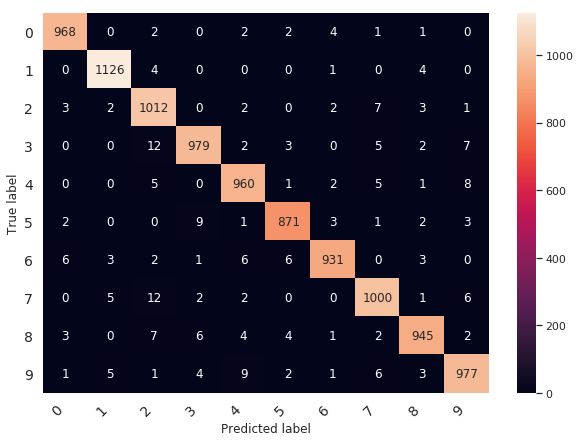

In [71]:
print_confusion_matrix(cm, classNames, figsize = (10,7), fontsize=14)

The image is actually : 6 but was predicted as: 5


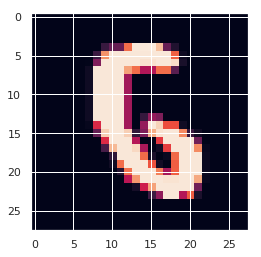

In [102]:
# find out indices where the predicted index and the actual index are not the same
bool_filter = p_test != y_test
indices_where_mismatch_occured = np.nonzero(bool_filter)[0]

#choose a random mismatch from the sequence
random_id = np.random.choice(indices_where_mismatch_occured)

# grab the image with that id
image = x_test[random_id]

# plot the image
print(f"The image is actually : {y_test[random_id][0]} but was predicted as: {int(p_test[random_id][0])}")
plt.imshow(image);